<a href="https://colab.research.google.com/github/shrutikanchugar/Segmentation/blob/main/Newsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Dense, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image




In [ ]:
# Define the dataset directory
dataset_dir = '/content/Dataset/Images'
segmentation_masks_dir = '/content/Dataset/Masks'

# Load images and their corresponding masks
def load_images_and_masks(img_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []
    for img_name in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)
        if os.path.exists(mask_path):
            img = Image.open(img_path).convert('L').resize(img_size)
            mask = Image.open(mask_path).convert('L').resize(img_size)
            images.append(np.array(img) / 255.0)
            masks.append(np.array(mask) / 255.0)
    return np.array(images), np.array(masks)

images, masks = load_images_and_masks(dataset_dir, segmentation_masks_dir)


In [ ]:
# Train-test split
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# Expand dimensions for compatibility with CNNs
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)


In [4]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    # Expansive Path
    u1 = UpSampling2D((2, 2))(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = UpSampling2D((2, 2))(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

unet = unet_model()
unet.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=8)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2674s 41s/step - accuracy: 0.7261 - loss: 0.5451 - val_accuracy: 0.8261 - val_loss: 0.4484
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2432s 37s/step - accuracy: 0.8263 - loss: 0.4111 - val_accuracy: 0.8347 - val_loss: 0.3739
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2339s 36s/step - accuracy: 0.8444 - loss: 0.3561 - val_accuracy: 0.8602 - val_loss: 0.3365
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2350s 37s/step - accuracy: 0.8688 - loss: 0.3181 - val_accuracy: 0.8600 - val_loss: 0.3336
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2373s 37s/step - accuracy: 0.8733 - loss: 0.3071 - val_accuracy: 0.8758 - val_loss: 0.3029
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2318s 36s/step - accuracy: 0.8860 - loss: 0.2793 - val_accuracy: 0.8887 - val_loss: 0.2708
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2422s 37s/step - accuracy: 0.8980 - loss: 0.2534 - val_accuracy: 0.9033 - val_loss: 0.2359
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2316s 36s/step - accuracy: 0.8997 - loss: 0.2431 - val_accu

In [5]:
def classification_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Instead of Flatten and Dense, use Conv2DTranspose to upsample
    u1 = UpSampling2D((2, 2))(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    u2 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u3 = UpSampling2D((2, 2))(c5)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u3)

    # Output layer with sigmoid activation and matching shape
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c6)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

4/4 ━━━━━━━━━━━━━━━━━━━━ 163s 40s/step


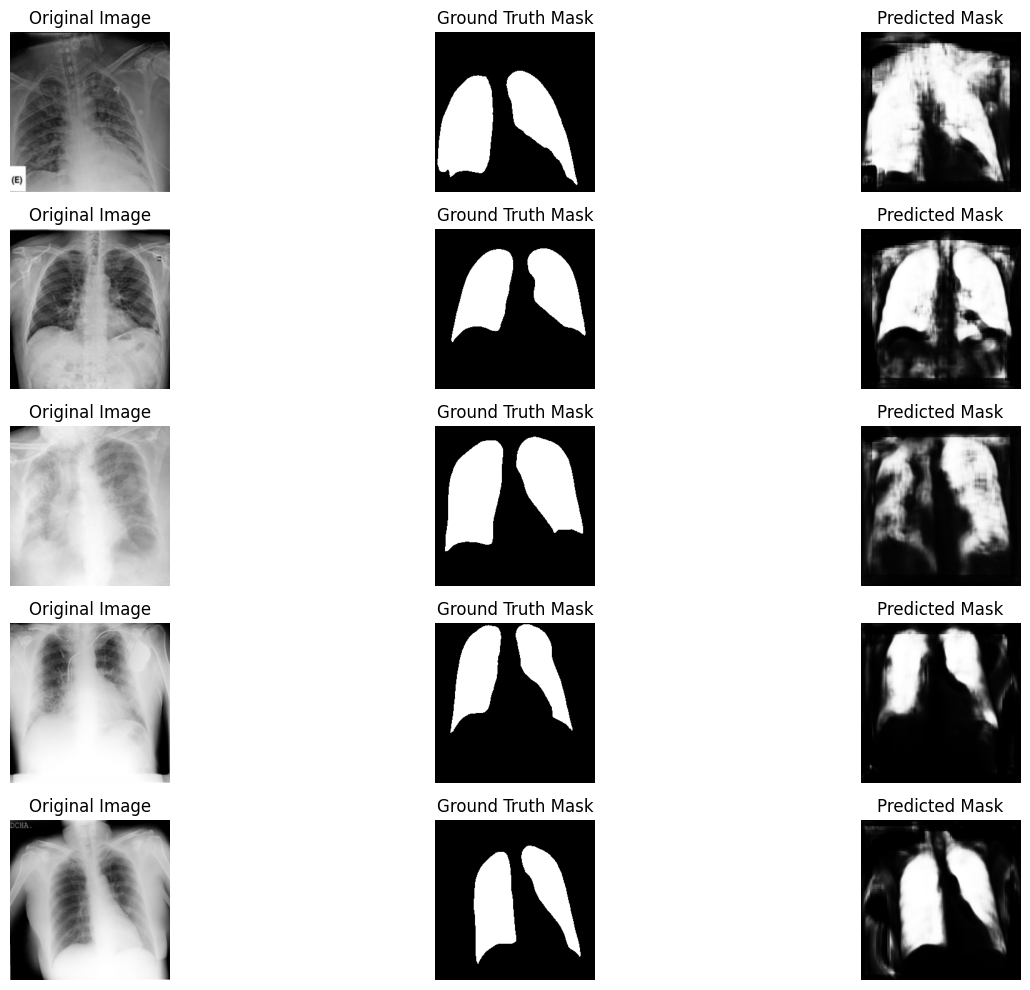

In [6]:
# Predict and visualize segmentation results
""" segmented_masks = unet.predict(x_val)
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(x_val[i].squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.subplot(3, 5, i+6)
    plt.imshow(segmented_masks[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.subplot(3, 5, i+11)
    plt.imshow(y_val[i].squeeze(), cmap='gray')
    plt.title("True Mask")
plt.tight_layout()
plt.show()
"""

def visualize_results(x_val, y_val, predicted_masks, num_samples=5):
    num_samples = min(num_samples, len(x_val)) # Ensure num_samples doesn't exceed data size
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(x_val[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(y_val[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predict masks on validation set
predicted_masks = unet.predict(x_val)

# Call the visualization function
visualize_results(x_val, y_val, predicted_masks, num_samples=5)


In [8]:
# Classification Model
def classification_model(input_size=(256, 256, 1), num_classes=3):
    inputs = Input(input_size)

    # Convolutional layers
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Flatten and fully connected layers
    f = Flatten()(p3)
    d1 = Dense(128, activation='relu')(f)
    d2 = Dense(64, activation='relu')(d1)
    outputs = Dense(num_classes, activation='softmax')(d2)  # For multi-class classification

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Generate synthetic classification labels (0: COVID, 1: Pneumonia, 2: Other)
classification_labels = np.random.randint(0, 3, len(images))  # Replace with actual labels
classification_labels = to_categorical(classification_labels, num_classes=3)
# Train-test split for classification
x_train_cls, x_val_cls, y_train_cls, y_val_cls = train_test_split(images, classification_labels, test_size=0.2, random_state=42)

# Now use x_train_cls, which is a subset of 'images', for training the classification model
classification_cnn = classification_model()
classification_cnn.fit(x_train_cls, y_train_cls, validation_data=(x_val_cls, y_val_cls), epochs=10, batch_size=8)

# Predict and display results
segmented_images = unet.predict(x_val)
classification_predictions = classification_cnn.predict(segmented_images)
predicted_classes = np.argmax(classification_predictions, axis=1)

# Display classification results
for i in range(5):
    print(f"Image {i+1}: Predicted Class - {predicted_classes[i]} (0: COVID, 1: Pneumonia, 2: Other)")

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.3346 - loss: 1.1433 - val_accuracy: 0.3543 - val_loss: 1.0958
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.3571 - loss: 1.0990 - val_accuracy: 0.3622 - val_loss: 1.0944
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.3985 - loss: 1.0934 - val_accuracy: 0.3701 - val_loss: 1.0992
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.4505 - loss: 1.0320 - val_accuracy: 0.3937 - val_loss: 1.1333
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.5377 - loss: 0.9565 - val_accuracy: 0.3228 - val_loss: 1.2592
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.6398 - loss: 0.7651 - val_accuracy: 0.3465 - val_loss: 1.4716
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.7334 - loss: 0.6482 - val_accuracy: 0.3386 - val_loss: 1.6087
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7759 - loss: 0.5442 - val_accuracy: 0.3386 - val

In the below output -
5 (top-left) is the number of correctly predicted "COVID" cases.
5 (middle) is the number of correctly predicted "Pneumonia" cases.
31 (bottom-right) is the number of correctly predicted "Other" cases.

8 is the number of "COVID" cases misclassified as "Pneumonia" (FN for COVID).
32 is the number of "COVID" cases misclassified as "Other" (FN for COVID).

9 ("Pneumonia" misclassified as "COVID") and 6 ("Other" misclassified as "COVID") are FP for COVID.

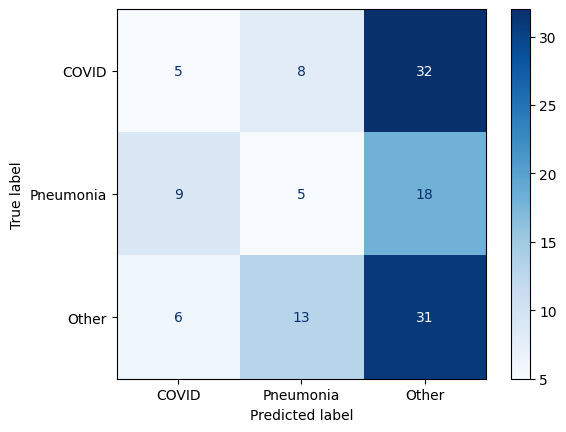

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predicted labels
true_classes = np.argmax(y_val_cls, axis=1)
predicted_classes = np.argmax(classification_predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['COVID', 'Pneumonia', 'Other'])
disp.plot(cmap='Blues')
plt.show()
